In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import joblib

In [2]:
# Load the dataset
data = pd.read_csv('Crop_production.csv')

In [3]:

# Preprocessing: Rename columns to strip any leading/trailing whitespace
data = data.rename(columns=lambda x: x.strip())

In [4]:
data

,Unnamed: 0,State_Name,Crop_Type,Crop,N,P,K,pH,rainfall,temperature,Area_in_hectares,Production_in_tons,Yield_ton_per_hec
0,0,andhra pradesh,kharif,cotton,120,40,20,5.46,654.34,29.266667,7300.0,9400.0,1.287671
1,1,andhra pradesh,kharif,horsegram,20,60,20,6.18,654.34,29.266667,3300.0,1000.0,0.303030
2,2,andhra pradesh,kharif,jowar,80,40,40,5.42,654.34,29.266667,10100.0,10200.0,1.009901
3,3,andhra pradesh,kharif,maize,80,40,20,5.62,654.34,29.266667,2800.0,4900.0,1.750000
4,4,andhra pradesh,kharif,moong,20,40,20,5.68,654.34,29.266667,1300.0,500.0,0.384615
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99844,99844,west bengal,rabi,wheat,60,30,30,6.70,152.54,22.280000,2013.0,5152.0,2.559364
99845,99845,west bengal,summer,maize,80,40,20,5.68,182.50,29.200000,258.0,391.0,1.515504
99846,99846,west bengal,summer,rice,80,40,40,5.64,182.50,29.200000,105.0,281.0,2.676190
99847,99847,west bengal,rabi,rice,80,40,40,5.42,152.54,22.280000,152676.0,261435.0,1.712352


In [5]:
data = data.drop(columns=['Unnamed: 0'])

In [6]:
data.shape

(99849, 12)

In [7]:
data.describe()

,N,P,K,pH,rainfall,temperature,Area_in_hectares,Production_in_tons,Yield_ton_per_hec
count,99849.000000,99849.000000,99849.000000,99849.000000,99849.000000,99849.000000,99849.000000,9.984900e+04,99849.000000
mean,69.816823,41.593656,42.037827,5.643624,701.151085,26.684154,16476.585668,3.776291e+04,3.931149
std,39.571469,15.056508,28.430263,0.505283,604.701552,4.851214,43604.268231,1.222447e+05,33.872242
min,10.000000,10.000000,10.000000,3.820000,3.274569,1.180000,0.580000,0.000000e+00,0.000000
25%,50.000000,40.000000,20.000000,5.360000,157.310000,23.106000,130.000000,1.620000e+02,0.586207
50%,75.000000,40.000000,30.000000,5.540000,579.750000,27.333333,1010.000000,1.506000e+03,1.329268
75%,80.000000,60.000000,50.000000,5.960000,1110.780000,29.266667,8099.000000,1.439500e+04,2.997288
max,180.000000,125.000000,200.000000,7.000000,3322.060000,35.346667,726300.000000,3.530571e+06,9801.000000


In [8]:
# Identify independent features including categorical features for one-hot encoding
categorical_features = ['State_Name', 'Crop_Type', 'Crop']
numerical_features = ['N', 'P', 'K', 'pH', 'rainfall', 'temperature', 'Area_in_hectares', 'Production_in_tons']

In [9]:
# # Function to remove outliers using IQR
# def remove_outliers(df, numerical_features):
#     for feature in numerical_features:
#         Q1 = df[feature].quantile(0.25)
#         Q3 = df[feature].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
#         df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
#     return df

In [10]:
# # Remove outliers from the numerical features
# filtered_data = remove_outliers(data, numerical_features)


In [11]:
# Filter out rows where any numerical independent feature is zero
filtered_data = data[~(data[numerical_features] == 0).any(axis=1)]

In [12]:
filtered_data.describe()

,N,P,K,pH,rainfall,temperature,Area_in_hectares,Production_in_tons,Yield_ton_per_hec
count,98437.000000,98437.000000,98437.000000,98437.000000,98437.000000,98437.000000,98437.000000,9.843700e+04,98437.000000
mean,69.841015,41.653596,41.969686,5.638774,697.780238,26.650578,16710.121655,3.830459e+04,3.987539
std,39.695287,14.866788,28.424172,0.501667,604.975837,4.864812,43871.755630,1.230340e+05,34.111018
min,10.000000,10.000000,10.000000,3.820000,3.274569,1.180000,0.580000,1.000000e-02,0.000514
25%,50.000000,40.000000,20.000000,5.360000,157.310000,22.890909,138.000000,1.810000e+02,0.607019
50%,75.000000,40.000000,30.000000,5.540000,579.750000,27.276000,1072.000000,1.600000e+03,1.355085
75%,80.000000,60.000000,50.000000,5.940000,1110.780000,29.266667,8400.000000,1.492000e+04,3.013099
max,180.000000,125.000000,200.000000,7.000000,3322.060000,35.346667,726300.000000,3.530571e+06,9801.000000


In [13]:
filtered_data.shape

(98437, 12)

In [15]:
from scipy.stats import zscore

# Calculate Z-scores for each numerical feature
z_scores = filtered_data[['N', 'P', 'K', 'pH', 'rainfall', 'temperature', 'Area_in_hectares', 'Production_in_tons', 'Yield_ton_per_hec']].apply(zscore)

# Identify outliers
outliers = z_scores[(z_scores > 3) | (z_scores < -3)]
print(outliers)

# Drop outliers (optional)
filtered_data = filtered_data[(z_scores < 3).all(axis=1)]
print(filtered_data)

        N   P   K  pH  rainfall  temperature  Area_in_hectares  \
0     NaN NaN NaN NaN       NaN          NaN               NaN   
1     NaN NaN NaN NaN       NaN          NaN               NaN   
2     NaN NaN NaN NaN       NaN          NaN               NaN   
3     NaN NaN NaN NaN       NaN          NaN               NaN   
4     NaN NaN NaN NaN       NaN          NaN               NaN   
...    ..  ..  ..  ..       ...          ...               ...   
99844 NaN NaN NaN NaN       NaN          NaN               NaN   
99845 NaN NaN NaN NaN       NaN          NaN               NaN   
99846 NaN NaN NaN NaN       NaN          NaN               NaN   
99847 NaN NaN NaN NaN       NaN          NaN          3.099182   
99848 NaN NaN NaN NaN       NaN          NaN               NaN   

       Production_in_tons  Yield_ton_per_hec  
0                     NaN                NaN  
1                     NaN                NaN  
2                     NaN                NaN  
3                  

In [16]:
filtered_data.describe()

,N,P,K,pH,rainfall,temperature,Area_in_hectares,Production_in_tons,Yield_ton_per_hec
count,91942.000000,91942.000000,91942.000000,91942.000000,91942.000000,91942.000000,91942.000000,91942.000000,91942.000000
mean,69.068434,41.358356,40.064660,5.635940,653.560754,26.726720,10727.884148,21551.898723,3.657201
std,39.892758,14.703209,25.483681,0.496434,527.918758,4.800550,24043.682046,53952.388664,6.952184
min,10.000000,10.000000,10.000000,3.820000,3.274569,1.180000,0.580000,0.010000,0.000514
25%,50.000000,40.000000,20.000000,5.360000,157.310000,23.106000,126.000000,163.000000,0.595968
50%,70.000000,40.000000,30.000000,5.540000,579.750000,27.276000,926.000000,1393.000000,1.318186
75%,80.000000,60.000000,45.000000,5.900000,1037.320000,29.266667,6788.750000,11812.000000,2.915088
max,180.000000,75.000000,120.000000,7.000000,2459.640000,35.346667,148300.000000,407250.000000,103.000000


In [17]:
filtered_data.shape

(91942, 12)

In [18]:
# Separate features and target
X = filtered_data[categorical_features + numerical_features]
y = filtered_data['Yield_ton_per_hec']

In [19]:
X.shape

(91942, 11)

In [20]:
# Define column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

In [21]:
# Define pipeline with preprocessor and RandomForestRegressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])


In [22]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
X_train.shape

(73553, 11)

In [24]:
X_test.shape

(18389, 11)

In [25]:
# Train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['N', 'P', 'K', 'pH',
                                                   'rainfall', 'temperature',
                                                   'Area_in_hectares',
                                                   'Production_in_tons']),
                                                 ('cat', OneHotEncoder(),
                                                  ['State_Name', 'Crop_Type',
                                                   'Crop'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [26]:
# Save the pipeline
joblib.dump(pipeline, 'rf_pipeline.pkl')

['rf_pipeline.pkl']

In [27]:
# Load the trained pipeline
pipeline = joblib.load('rf_pipeline.pkl')

In [28]:
# Make predictions on the test set
y_pred = pipeline.predict(X_test)


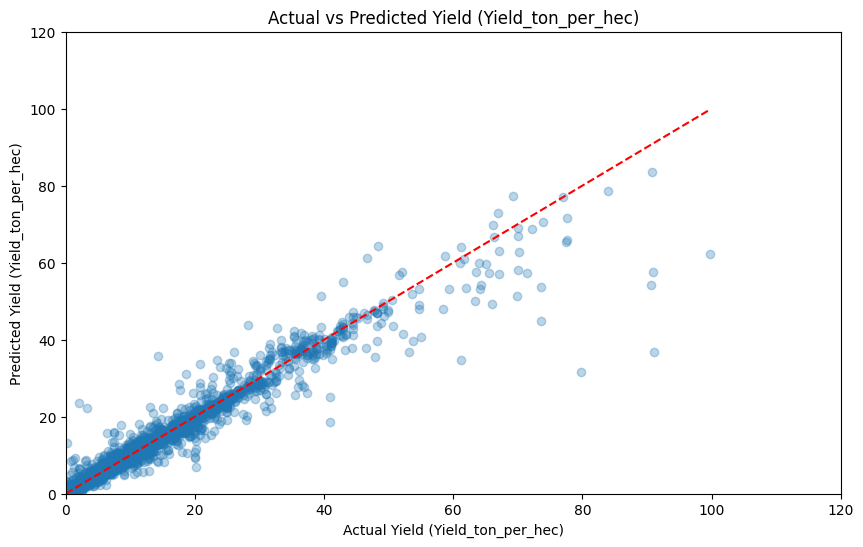

In [29]:
# Plot actual vs. predicted values with limited axes
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlim(0, 120)
plt.ylim(0, 120)
plt.xlabel('Actual Yield (Yield_ton_per_hec)')
plt.ylabel('Predicted Yield (Yield_ton_per_hec)')
plt.title('Actual vs Predicted Yield (Yield_ton_per_hec)')
plt.show()

In [33]:
y_test.describe()

count    18389.000000
mean         3.650295
std          6.929491
min          0.003189
25%          0.600000
50%          1.318052
75%          2.927037
max         99.750000
Name: Yield_ton_per_hec, dtype: float64

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming y_true and y_pred are your true and predicted values
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("MAE:", mae)
print("R^2:", r2)


MSE: 1.5692824085736832
MAE: 0.2948939985396436
R^2: 0.9673169927814657
